# Data cleaning

In [9]:
#import pandas and numpy package
import pandas as pd
import numpy as np 
#insert file_path for the data
file_path = 'C:/Users/anton/Documents/2de_master/Thesis/Code/analysis/Data/2. airbnb_data/Paris/Paris all detailed listings/Paris_Q1_detailed_listings.xlsx'
#read data, and quickly check if it is correctly read in
dataframe1= pd.read_excel(file_path)

In [ ]:
print(dataframe1.dtypes)

In [10]:
columns_to_drop =["id","name","description","host_location","host_thumbnail_url","host_name","bathrooms",
                  "listing_url","scrape_id","last_scraped", "host_picture_url","host_url", "host_has_profile_pic", 
                  "host_verifications","source","calendar_last_scraped","license","picture_url","host_about",
                             "neighbourhood","neighbourhood_group_cleansed","minimum_minimum_nights",
                             "maximum_minimum_nights","minimum_maximum_nights","maximum_maximum_nights",
                             "minimum_nights_avg_ntm","maximum_nights_avg_ntm","calendar_updated",
                             "neighborhood_overview","host_neighbourhood", "host_acceptance_rate"]
dataframe1 = dataframe1.drop(columns_to_drop, axis=1)

#solving trailing white space problem
string_columns = dataframe1.select_dtypes(include='object').columns.tolist()
for i in string_columns:
    dataframe1[i] = dataframe1[i].str.strip()

#missing values have always been checked with the function: print(dataframe1.isnull().mean()) 

#host_repsonse_time, filling in the empty ones with "unknown"
dataframe1.host_response_time.fillna("unknown", inplace=True)
dataframe1.host_response_time.value_counts(normalize=True)

#adapting the host_response_rate column to better fit
# Removing the % sign from the host_response_rate string and converting to an integer
dataframe1.host_response_rate = dataframe1.host_response_rate.str[:-1].astype('float64')
# Bin into four categories
dataframe1.host_response_rate = pd.cut(dataframe1.host_response_rate, bins=[0, 50, 90, 99, 100], labels=['0-49%', '50-89%', '90-99%', '100%'], include_lowest=True)
# Converting to string
dataframe1.host_response_rate = dataframe1.host_response_rate.astype('str')
# Replace nulls with 'unknown'
dataframe1.host_response_rate.replace('nan', 'unknown', inplace=True)

#these rows do not have that big of a missing value amount so we just delete the missing value rows here
col = ["host_since","host_identity_verified","host_listings_count","host_total_listings_count","host_is_superhost"]
for column in col:
    dataframe1.dropna(subset=[column], inplace=True)

# Category counts
dataframe1.host_response_rate.value_counts()
#fill out all NaN within string columns with ''
for column in string_columns:
    dataframe1[column] = dataframe1[column].fillna("")   

#fixing the "bathroom_text" column to only numbers and renaming it
import re
def extract_numeric(value):
    numeric_part = re.search(r'\d+\.\d+|\d+', str(value))
    return float(numeric_part.group()) if numeric_part else None
dataframe1['bathrooms_text'] = dataframe1['bathrooms_text'].apply(extract_numeric)
dataframe1.rename(columns={'bathrooms_text': 'bathrooms'}, inplace=True)

#adding a column with the information if a listing has a review or not
dataframe1['zero_reviews'] = dataframe1['number_of_reviews'] == 0
    
#delete those that have no information about both beds and bedrooms
dataframe1.dropna(subset=['beds', 'bedrooms'], how='all', inplace=True)

#dropping those with +4 bedrooms (outliers) and no information about bedroom and between 1-4 beds is a studio so 0 bedrooms
dataframe1.loc[(dataframe1['bedrooms'].isnull()) & (dataframe1['beds'].between(1, 4)), 'bedrooms'] = 0
dataframe1.drop(dataframe1[(dataframe1['bedrooms'].isnull()) & (dataframe1['beds'] > 4)].index, inplace=True)

#fill in all the other empty values with the amount of bedrooms 
dataframe1['beds'].fillna(dataframe1['bedrooms'], inplace=True)

#dropping those that still have no bedroom amount 
dataframe1.dropna(subset=["bedrooms"], inplace=True)

#dropping those that still have no bathroom amount 
dataframe1.dropna(subset=["bathrooms"], inplace=True)

from datetime import datetime 
dataframe1['first_review'] = pd.to_datetime(dataframe1['first_review']) 
# Calculating the number of days
dataframe1['days_since_first_review'] = (datetime(2024, 1, 20) - dataframe1['first_review']).dt.days
# Printing descriptives
#dataframe1.hist(['days_since_first_review'], figsize=(15,5), bins=[0, 1*365, 2*365, 3*365, 4*365, 5*365, 6*365, 7*365, 8*365, 10*365, 11*365]), 9*365
#DOING Binning time since last review
dataframe1['days_since_first_first_review'] = pd.qcut(dataframe1['days_since_first_review'], q=5,
                              labels=['Extremely active', 'Very active', 'Active', 'Inactive', 'Slumbering'])

dataframe1['last_review'] = pd.to_datetime(dataframe1['last_review']) 
# Calculating the number of days
dataframe1['days_since_last_review'] = (datetime(2024, 1, 20) - dataframe1['last_review']).dt.days
# Printing descriptives
#dataframe1.hist(['days_since_last_review'], figsize=(15,5), bins=[0, 1*365, 2*365, 3*365, 4*365, 5*365, 6*365, 7*365, 8*365, 10*365, 11*365]), 9*365
#DOING Binning time since last review
dataframe1['days_since_last_last_review'] = pd.qcut(dataframe1['days_since_last_review'], q=5,
                              labels=['Extremely active', 'Very active', 'Active', 'Inactive', 'Slumbering'])

dataframe1['host_since'] = pd.to_datetime(dataframe1['host_since']) 
# Calculating the number of days
dataframe1['days_since_host'] = (datetime(2024, 1, 20) - dataframe1['host_since']).dt.days
# Printing descriptives
#dataframe1.hist(['days_since_host'], figsize=(15,5), bins=[0, 1*365, 2*365, 3*365, 4*365, 5*365, 6*365, 7*365, 8*365, 10*365, 11*365]), 9*365
#DOING Binning time since last review
dataframe1['days_since_host_host'] = pd.qcut(dataframe1['days_since_host'], q=5,
                              labels=['Extremely active', 'Very active', 'Active', 'Inactive', 'Slumbering'])

#Simplifying the property_types in to 4 categories
dataframe1.property_type.replace({
    'Barn': 'House',
    'Boat': 'Other',
    'Bus': 'Other',
    'Camper/RV': 'Other',
    'Casa particular': 'House',
    'Cave': 'Other',
    'Dome': 'Other',
    'Earthen home': 'House',
    'Entire bed and breakfast': 'Hotel',    
    'Entire bungalow': 'House',
    'Entire condo': 'Apartmen',
    'Entire guesthouse': 'House',
    'Entire home': 'House',
    'Entire guest suite': 'Apartment',
    'Entire rental unit': 'Apartment',
    'Entire loft': 'Apartment',
    'Entire home/apt': 'House',
    'Entire place': 'House',
    'Entire serviced apartment': 'Apartment',
    'Entire townhouse': 'House',
    'Entire villa': 'House',
    'Entire vacation home': 'House',
    'Floor': 'Other',
    'Houseboat': 'Other',
    'Private room': 'Apartment',
    'Island': 'Other',
    'Private room in bed and breakfast': 'Hotel',    
    'Private room in boat': 'Other',
    'Private room in casa particular': 'House',
    'Private room in condo': 'Apartment',
    'Private room in guest suite': 'Apartment',
    'Private room in earthen home': 'House',
    'Private room in home': 'House',
    'Private room in guesthouse': 'House',
    'Private room in loft': 'Apartment',
    'Private room in hostel': 'Hotel',
    'Private room in rental unit': 'Apartment',
    'Private room in townhouse': 'House',
    'Private room in tiny home': 'House',
    'Private room in serviced apartment': 'Apartment',
    'Room in bed and breakfast': 'Hotel',
    'Private room in villa': 'House',
    'Room in serviced apartment': 'Apartment',
    'Room in boutique hotel': 'Hotel',
    'Room in hotel': 'Hotel',
    'Room in hostel': 'Hotel',
    'Shared room in bed and breakfast': 'Hotel',
    'Shared room in boutique hotel': 'Hotel',
    'Shared room in cabin': 'Other',
    'Shared room in boat': 'Other',
    'Shared room in condo': 'Apartment',
    'Shared room in farm stay': 'Other',
    'Shared room in guesthouse': 'House',
    'Shared room in casa particular': 'House',
    'Shared room in ice dome': 'Other',
    'Shared room in home': 'House',
    'Shared room in hostel': 'Hotel',
    'Shared room in hotel': 'Hotel',
    'Shared room in rental unit': 'Apartment',
    'Tiny home': 'House',
    'Shared room in loft': 'Apartment',
    'Shared room in townhouse': 'House',
    'Shared room in tiny home': 'House',
    }, inplace=True)

# Replacing other categories with 'other'
dataframe1.loc[~dataframe1.property_type.isin(['House', 'Apartment','Hotel']), 'property_type'] = 'Other'
#dataframe1['property_type'].value_counts()

#changing the name from neighbourhoud_cleansed to neighbourhood
dataframe1.rename(columns={'neighbourhood_cleansed': 'neighbourhood'}, inplace=True)

#convert the necessary columns to a boolean type, which is easier to use
columns_to_convert = ['host_is_superhost', 'instant_bookable', 'host_identity_verified',"has_availability"] 
for column in columns_to_convert:
    dataframe1[column] = dataframe1[column].replace({'f': False, 't': True}).astype(bool)

In [ ]:
#not necessary anymore
#list_amenities = list(dataframe1.amenities)
#amenities_list_string = " ".join(list_amenities)
#amenities_list_string = amenities_list_string.replace('{', '')
#amenities_list_string = amenities_list_string.replace('}', ',')
#amenities_list_string = amenities_list_string.replace('"', '')
#amenities_set = [x.strip() for x in amenities_list_string.split(',') if x.strip()]
#amenities_set = set(amenities_set)
#amenities_set

In [12]:
#package that can help us with making it lists
import ast
# Convert the string representation of lists to actual lists
dataframe1["amenities"] = dataframe1["amenities"].apply(ast.literal_eval)

In [19]:
#making a unique list out of all the different kind of amenities that there are
unique_items_set = set.union(*dataframe1["amenities"].apply(set))
print(unique_items_set)
print(len(unique_items_set)) #first we come to around 5800 different amenities

{'Building staff', 'stove', 'Shower gel', 'Blender', 'Cleaning products', 'Sound system', 'Central heating', 'Shared patio or balcony', 'Free dryer – In unit', 'Baby monitor', 'Private patio or balcony', 'coffee', 'Dining table', 'Lockbox', 'oven', 'Window guards', 'Hammock', 'Mosquito net', 'Trash compactor', 'Heating', 'Elevator', 'wifi', 'Microwave', 'Bidet', 'Rice maker', 'Baby safety gates', 'Private living room', 'Window AC unit', 'view', 'Smoking allowed', 'Long term stays allowed', 'hot tub', 'Dishes and silverware', 'refrigerator', 'game console', 'Bathtub', 'clothing storage', 'toys children', 'Room-darkening shades', 'Cleaning available during stay', 'tv', 'Changing table', 'Single level home', 'Wine glasses', 'Washer –\xa0In unit', 'Pets allowed', 'Bread maker', 'Fireplace guards', 'Outdoor shower', 'Free dryer', 'Hangers', 'Carbon monoxide alarm', 'Free washer', 'exercise equipment', 'Air conditioning', 'Barbecue utensils', 'Free washer – In building', 'Hot water kettle', 

In [14]:
#with the code down below we will simplify the amenities to reduce the amount of amenities

oven_items_set = {item for item in unique_items_set if 'oven' in item.lower()}
def replace_oven_items(item_list):
    return ['oven' if item in oven_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_oven_items)

soap_items_set = {item for item in unique_items_set if 'soap' in item.lower()}
def replace_soap_items(item_list):
    return ['soap' if item in soap_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_soap_items)

shampoo_items_set = {item for item in unique_items_set if 'shampoo' in item.lower()}
def replace_shampoo_items(item_list):
    return ['shampoo' if item in shampoo_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_shampoo_items)

wifi_items_set = {item for item in unique_items_set if 'wifi' in item.lower()}
def replace_wifi_items(item_list):
    return ['wifi' if item in wifi_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_wifi_items)

special_items_set = {item for item in unique_items_set if any(keyword in item for keyword in ['Netflix', 'Disney+', 'Amazon Prime'])}
def replace_and_add_broadcast(item_list):
    # Replace items from special_items_set with 'Broadcast'
    item_list = ['broadcast' if item in special_items_set else item for item in item_list]
    # Add 'TV' to the list if modified
    modified = any(item == 'broadcast' for item in item_list)
    if modified:
        item_list.append('TV')
    return item_list
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_and_add_broadcast)

tv_items_set = {item for item in unique_items_set if 'tv' in item.lower()}
def replace_tv_items(item_list):
    return ['tv' if item in tv_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_tv_items)

ref_items_set = {item for item in unique_items_set if 'refrigerator' in item.lower()}
def replace_ref_items(item_list):
    return ['refrigerator' if item in ref_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_ref_items)

coffee_items_set = {item for item in unique_items_set if 'coffee' in item.lower()}
def replace_coffee_items(item_list):
    return ['coffee' if item in coffee_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_coffee_items)

sound_items_set = {item for item in unique_items_set if any(keyword in item for keyword in ['sound system', 'Bluetooth'])}
def replace_sound_items(item_list):
    item_list = ['sound system' if item in sound_items_set else item for item in item_list]
    return item_list
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_sound_items)

stove_items_set = {item for item in unique_items_set if 'stove' in item.lower()}
def replace_stove_items(item_list):
    return ['stove' if item in stove_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_stove_items)

cond_items_set = {item for item in unique_items_set if 'conditioner' in item.lower()}
def replace_cond_items(item_list):
    return ['conditioner' if item in cond_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_cond_items)

park_items_set = {item for item in unique_items_set if 'parking' in item.lower()}
def replace_park_items(item_list):
    return ['parking' if item in park_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_park_items)

clothing_items_set = {item for item in unique_items_set if 'clothing storage' in item.lower()}
def replace_clothing_items(item_list):
    return ['clothing storage' if item in clothing_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_clothing_items)

exercise_items_set = {item for item in unique_items_set if 'exercise equipment' in item.lower()}
def replace_exercise_items(item_list):
    return ['exercise equipment' if item in exercise_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_exercise_items)

children_items_set = {item for item in unique_items_set if 'children' in item.lower()}
def replace_children_items(item_list):
    return ['toys children' if item in children_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_children_items)

bbq_items_set = {item for item in unique_items_set if 'bbq' in item.lower()}
def replace_bbq_items(item_list):
    return ['bbq' if item in bbq_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_bbq_items)

pool_items_set = {item for item in unique_items_set if 'pool' in item.lower()}
def replace_pool_items(item_list):
    return ['pool' if item in pool_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_pool_items)

hot_items_set = {item for item in unique_items_set if 'hot tub' in item.lower()}
def replace_hot_items(item_list):
    return ['hot tub' if item in hot_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_hot_items)

backyard_items_set = {item for item in unique_items_set if 'backyard' in item.lower()}
def replace_backyard_items(item_list):
    return ['backyard' if item in backyard_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_backyard_items)

gym_items_set = {item for item in unique_items_set if 'gym' in item.lower()}
def replace_gym_items(item_list):
    return ['gym' if item in gym_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_gym_items)

view_items_set = {item for item in unique_items_set if 'view' in item.lower()}
def replace_view_items(item_list):
    return ['view' if item in view_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_view_items)

crib_items_set = {item for item in unique_items_set if 'crib' in item.lower()}
def replace_crib_items(item_list):
    return ['crib' if item in crib_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_crib_items)

gc_items_set = {item for item in unique_items_set if 'game console' in item.lower()}
def replace_gc_items(item_list):
    return ['game console' if item in gc_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_gc_items)

In [15]:
#last step to clean the amenities is removing the ones that do not appear 100 times or more in the column
from collections import Counter
flat_list = [word for sublist in dataframe1["amenities"] for word in sublist]
word_counts = Counter(flat_list)
filtered_word_set = {word for word, count in word_counts.items() if count < 100}
common_elements = list(filtered_word_set & unique_items_set)

def remove_common_elements(item_list):
    return [item for item in item_list if item not in common_elements]
dataframe1['amenities'] = dataframe1['amenities'].apply(remove_common_elements)

#only 132 unique items left, which is an acceptable amount and now we can make columns out of these ones

In [23]:
#making new columns for the amenities indivually with a 0 or 1 inside of them 
for item in unique_items_set:
    dataframe1[item] = dataframe1["amenities"].apply(lambda x: int(item in x))

In [24]:
#now we will be able to remove the 'amenities' column
dataframe1 = dataframe1.drop('amenities', axis=1)

# Data exploration

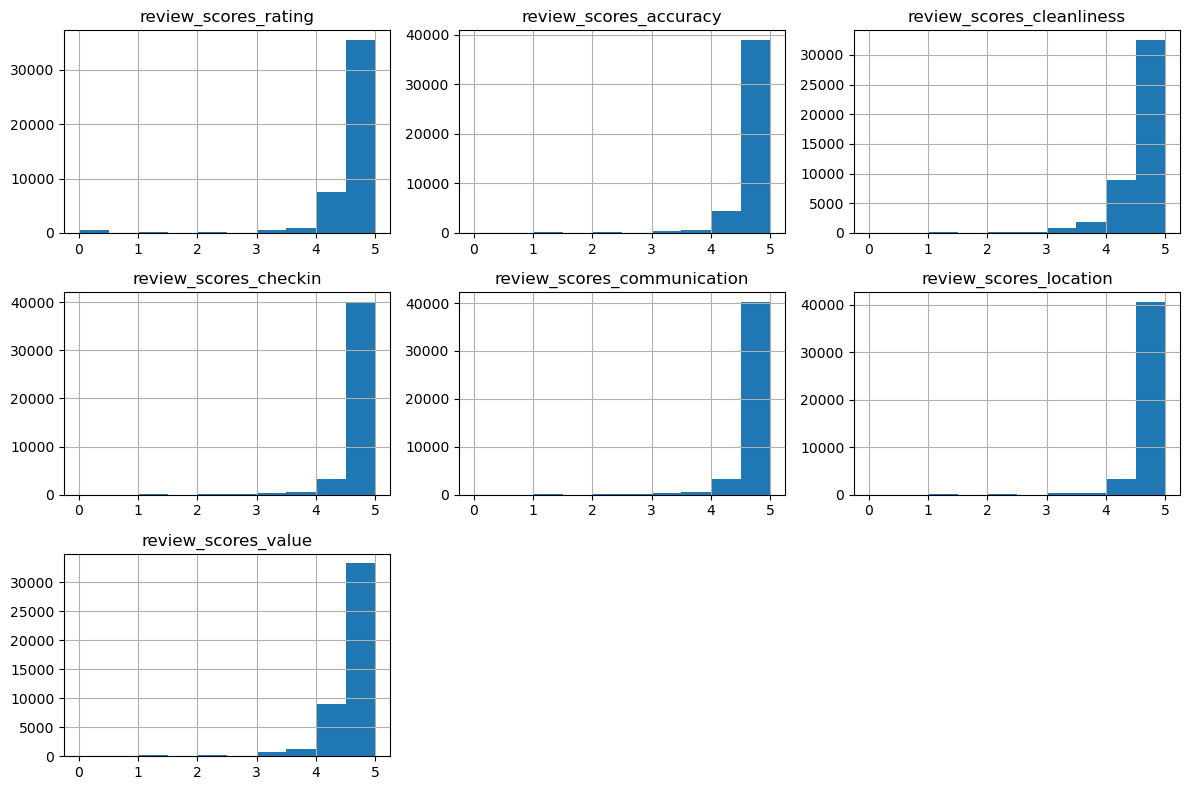

In [25]:
# Checking the distributions of the review ratings columns
import matplotlib
import matplotlib.pyplot as plt
variables_to_plot = list(dataframe1.columns[dataframe1.columns.str.startswith("review_scores") == True])
fig = plt.figure(figsize=(12,8))
for i, var_name in enumerate(variables_to_plot):
    ax = fig.add_subplot(3,3,i+1)
    dataframe1[var_name].hist(bins=10,ax=ax)
    ax.set_title(var_name)
fig.tight_layout()
plt.show()

#out of these we see that most of them are rated quite positive, with the biggest amount around 4-5/5 stars

In [26]:
# Importing the Paris neighbourhood  GeoJSON file as a dataframe in geopandas
import geopandas as gpd
map_dataframe1 = gpd.read_file('C:/Users/anton/Documents/2de_master/Thesis/Code/analysis/Data/2. airbnb_data/Paris/Q1 airbnb_data Paris/neighbourhoods.geojson')
map_dataframe1.drop('neighbourhood_group', axis = 1, inplace = True)
map_dataframe1.head(20)

,neighbourhood,geometry
0,Batignolles-Monceau,"MULTIPOLYGON (((2.29517 48.87396, 2.29504 48.8..."
1,Palais-Bourbon,"MULTIPOLYGON (((2.32090 48.86306, 2.32094 48.8..."
2,Buttes-Chaumont,"MULTIPOLYGON (((2.38943 48.90122, 2.39014 48.9..."
3,Opéra,"MULTIPOLYGON (((2.33978 48.88203, 2.33982 48.8..."
4,Entrepôt,"MULTIPOLYGON (((2.36469 48.88437, 2.36485 48.8..."
5,Gobelins,"MULTIPOLYGON (((2.37491 48.83801, 2.37698 48.8..."
6,Vaugirard,"MULTIPOLYGON (((2.29932 48.85217, 2.30088 48.8..."
7,Reuilly,"MULTIPOLYGON (((2.41388 48.83357, 2.41401 48.8..."
8,Louvre,"MULTIPOLYGON (((2.32801 48.86992, 2.32997 48.8..."
9,Luxembourg,"MULTIPOLYGON (((2.34459 48.85405, 2.34428 48.8..."


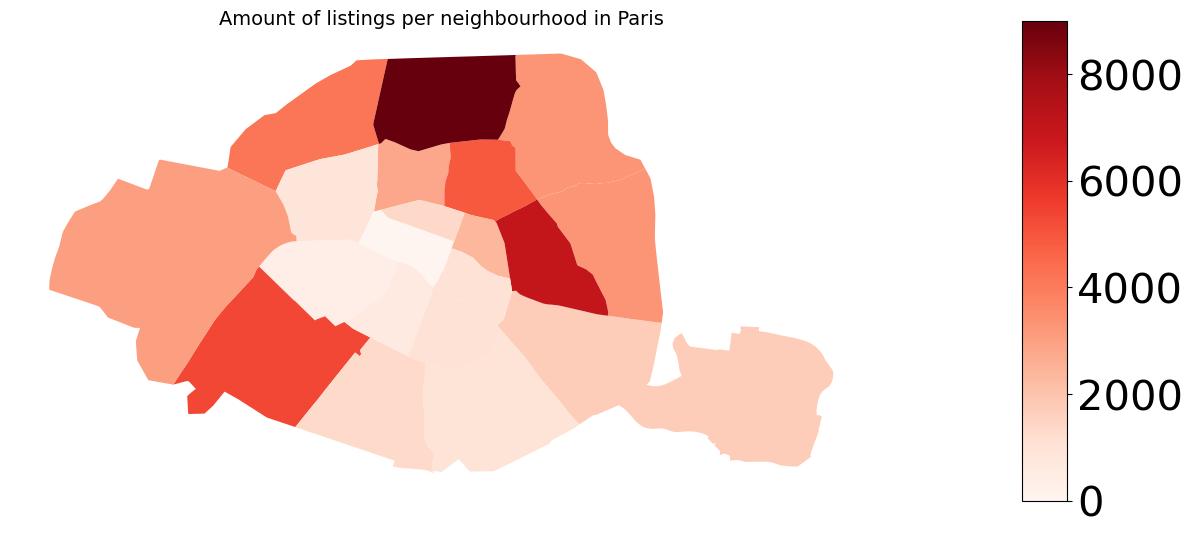

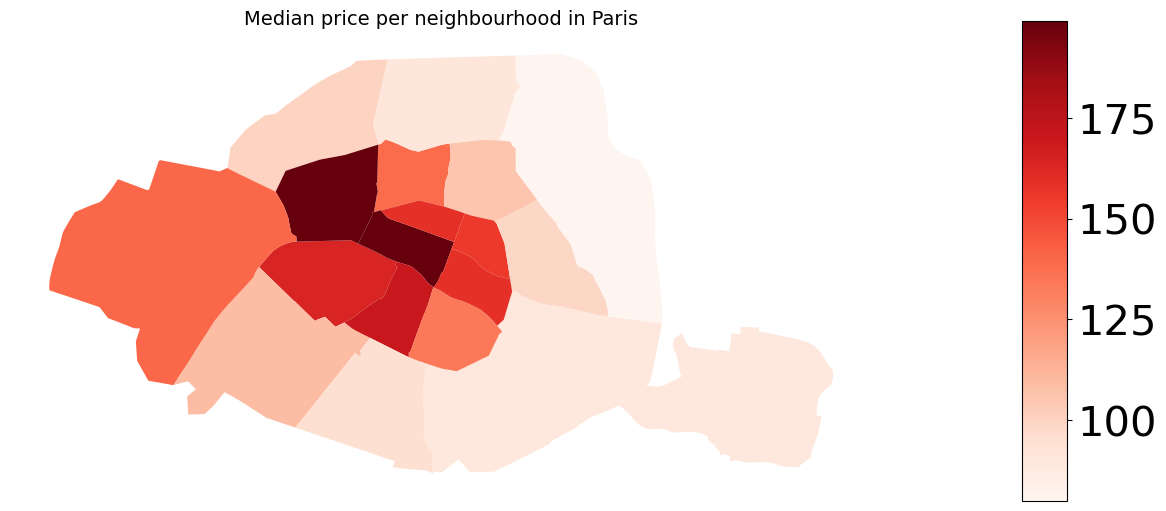

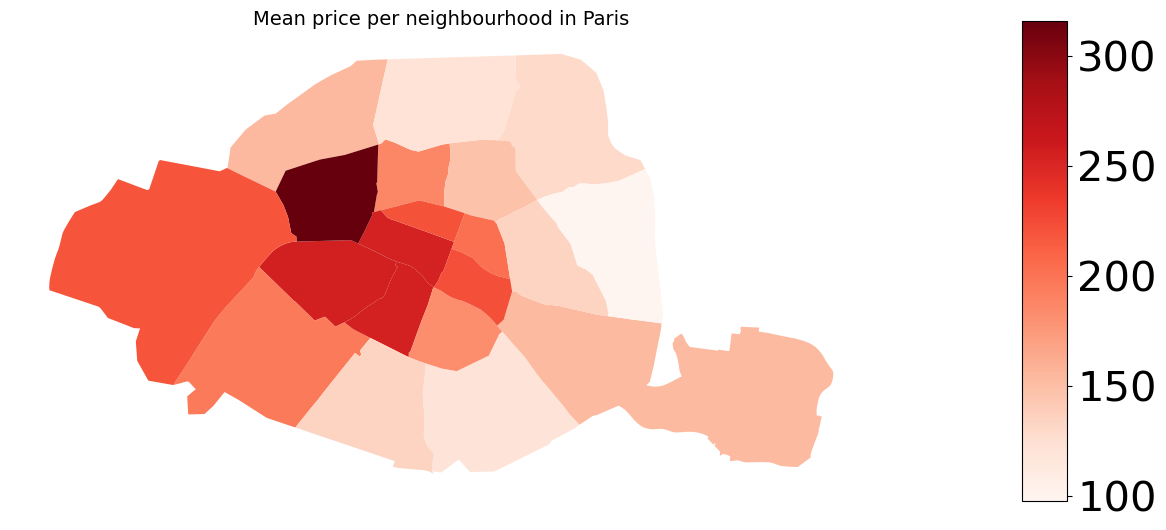

                     number_of_listings  median_price  mean_price
neighbourhood                                                    
Batignolles-Monceau                3590         100.0  153.356267
Bourse                             2064         159.0  220.521318
Buttes-Chaumont                    3124          80.0  129.913252
Buttes-Montmartre                  6211          91.0  121.977942
Entrepôt                           3986         106.0  147.635223
Gobelins                           1865          90.0  120.163539
Hôtel-de-Ville                     1901         159.0  222.794319
Louvre                             1338         199.0  254.000747
Luxembourg                         1651         170.0  254.671108
Ménilmontant                       3116          80.0   97.531772
Observatoire                       2051          95.0  133.746465
Opéra                              2853         139.0  186.611286
Palais-Bourbon                     1530         164.0  255.744444
Panthéon  

In [27]:
#setting the characteristics for the following plot
plt.rcParams.update({'font.size': 30})
plt.rcParams['figure.figsize'] = 280, 280


# Creating a dataframe of listing counts and median price by neighbourhood
neighbourhood_dataframe1 = pd.DataFrame(dataframe1.groupby('neighbourhood').size())
neighbourhood_dataframe1.rename(columns={0: 'number_of_listings'}, inplace=True)
neighbourhood_dataframe1['median_price'] = dataframe1.groupby('neighbourhood').price.median().values
neighbourhood_dataframe1['mean_price'] = dataframe1.groupby('neighbourhood').price.mean().values

# Putting the dataframes together
neighbourhood_map_dataframe1 = map_dataframe1.set_index('neighbourhood').join(neighbourhood_dataframe1)
                  
# Plotting the number of listings in each neighbourhood
fig1, ax1 = plt.subplots(1, figsize=(15, 6)) #deciding on plot size
neighbourhood_map_dataframe1.plot(column='number_of_listings', cmap='Reds', ax=ax1, rasterized=True) 
#rasterized to makes it easier for big data sets + ax1 earlier defined

ax1.axis('off') #disabling the axis components, including axis labels, ticks, and the frame surrounding the plot
ax1.set_title('Amount of listings per neighbourhood in Paris', fontsize=14)
cax1 = fig1.add_axes([0.9, 0.1, 0.03, 0.8]) # Adjusted the position and size as needed for the side axis [left, bottom, width, height]
#ScalarMappable to make a color map + norm, to normalize the coloring within the graph 
sm1 = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=0, vmax=9000))
sm1._A = [] # The primary reason for doing this is to provide an empty array that will later be populated with the data range when the plot is created. The colorbar uses this array to decide the color scaling for the colormap.
cbar1 = fig1.colorbar(sm1, cax=cax1) 
plt.show()

# Plotting the median price of listings in each neighbourhood
fig2, ax2 = plt.subplots(1, figsize=(15, 6))
neighbourhood_map_dataframe1.plot(column='median_price', cmap='Reds', ax=ax2)
ax2.axis('off')
ax2.set_title('Median price per neighbourhood in Paris', fontsize=14)
cax2 = fig2.add_axes([0.9, 0.1, 0.03, 0.8])  # Adjusted the position and size as needed for the side axis [left, bottom, width, height]
#ScalarMappable to make a color map + norm, to normalize the coloring within the graph 
sm2 = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=min(neighbourhood_map_dataframe1.median_price), vmax=max(neighbourhood_map_dataframe1.median_price))) 
sm2._A = [] # The primary reason for doing this is to provide an empty array that will later be populated with the data range when the plot is created. The colorbar uses this array to decide the color scaling for the colormap.
cbar2 = fig2.colorbar(sm2, cax=cax2)
plt.show()

# Plotting the mean price of listings in each neighbourhood
fig3, ax3 = plt.subplots(1, figsize=(15, 6))
neighbourhood_map_dataframe1.plot(column='mean_price', cmap='Reds', ax=ax3)
ax3.axis('off')
ax3.set_title('Mean price per neighbourhood in Paris', fontsize=14)
cax3 = fig3.add_axes([0.9, 0.1, 0.03, 0.8])  # Adjusted the position and size as needed for the side axis [left, bottom, width, height]
#ScalarMappable to make a color map + norm, to normalize the coloring within the graph 
sm3 = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=min(neighbourhood_map_dataframe1.mean_price), vmax=max(neighbourhood_map_dataframe1.mean_price))) 
sm3._A = [] # The primary reason for doing this is to provide an empty array that will later be populated with the data range when the plot is created. The colorbar uses this array to decide the color scaling for the colormap.
cbar3 = fig3.colorbar(sm3, cax=cax3)
plt.show()

print(neighbourhood_dataframe1)

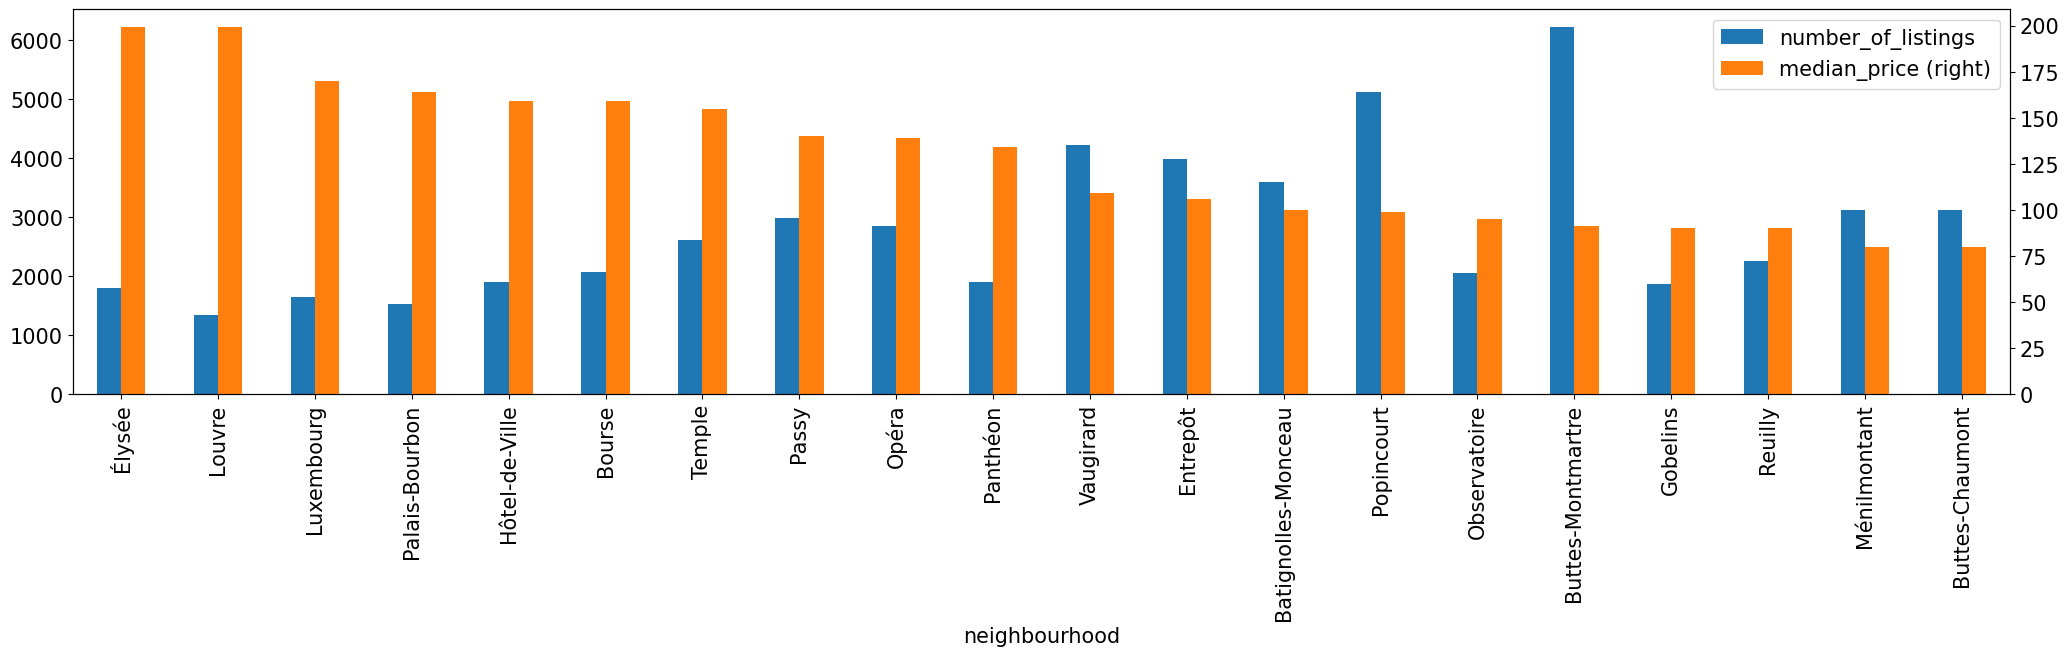

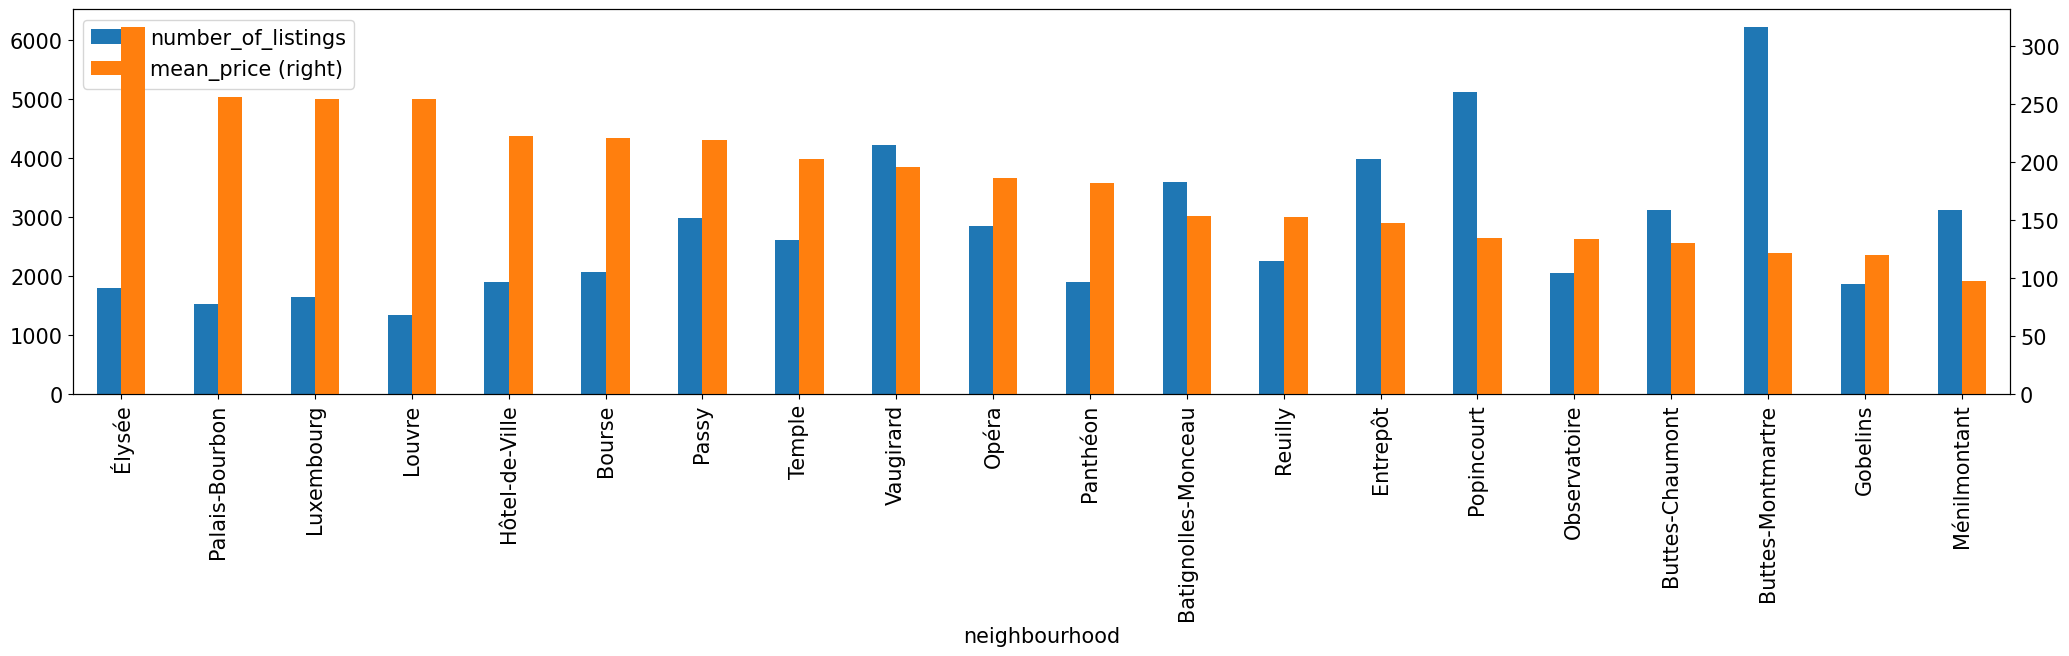

In [28]:
# Plot number of listings and median price in one bar plot
plt.rcParams['font.size'] = 15
plt.rcParams['figure.figsize'] = 25, 5
selected_columns = ['number_of_listings', 'median_price']
neighbourhood_dataframe1_selected = neighbourhood_dataframe1[selected_columns]
neighbourhood_dataframe1_sorted = neighbourhood_dataframe1_selected.sort_values('median_price', ascending=False)
neighbourhood_dataframe1_sorted.plot( kind= 'bar' , secondary_y= 'median_price' , rot= 90 )
plt.xticks(rotation='vertical')
plt.show()

# Plot number of listings and mean price in one bar plot
plt.rcParams['font.size'] = 15
plt.rcParams['figure.figsize'] = 25, 5
selected_columns = ['number_of_listings', 'mean_price']
neighbourhood_dataframe1_selected = neighbourhood_dataframe1[selected_columns]
neighbourhood_dataframe1_sorted = neighbourhood_dataframe1_selected.sort_values('mean_price', ascending=False)
neighbourhood_dataframe1_sorted.plot( kind= 'bar' , secondary_y= 'mean_price' , rot= 90 )
plt.xticks(rotation='vertical')
plt.show()

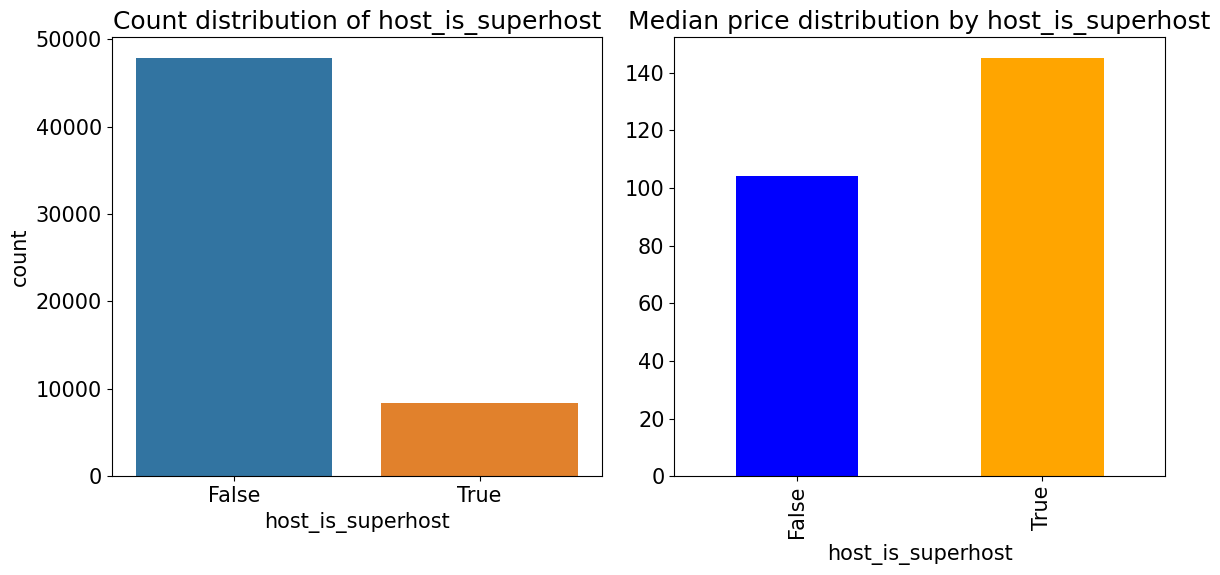

% Wise Split of host_is_superhost:
host_is_superhost
False    85.107709
True     14.892291
Name: proportion, dtype: float64

P-value for host_is_superhost: 1.636312609285787e-26
host_is_superhost
False    0.851077
True     0.148923
Name: proportion, dtype: float64


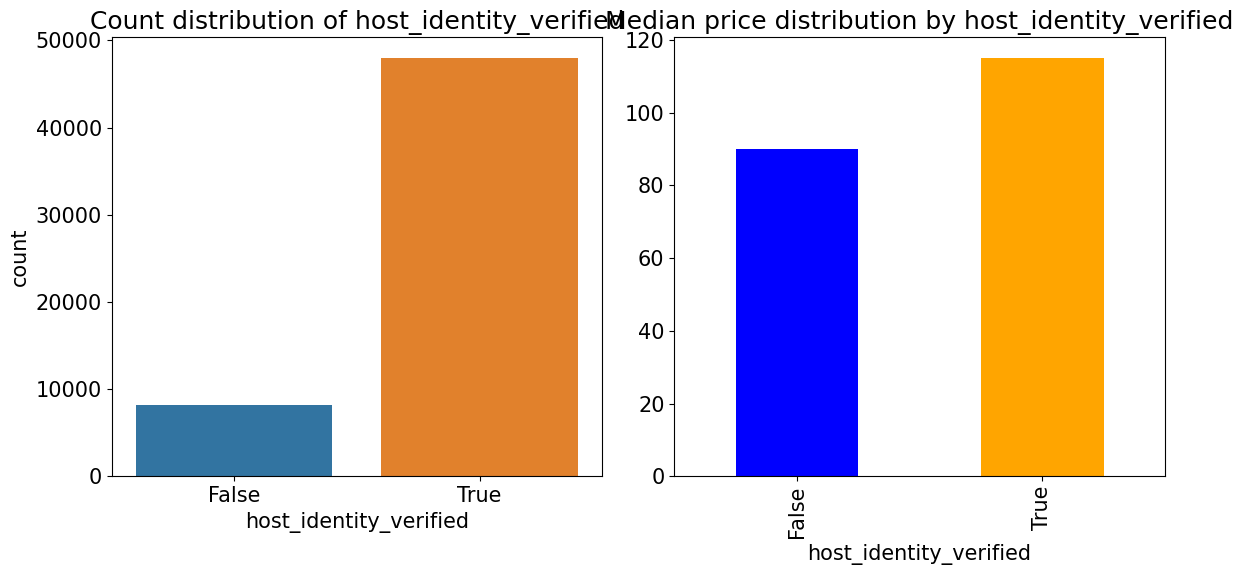

% Wise Split of host_identity_verified:
host_identity_verified
True     85.364073
False    14.635927
Name: proportion, dtype: float64

P-value for host_identity_verified: 5.360416694143018e-08
host_identity_verified
True     0.853641
False    0.146359
Name: proportion, dtype: float64


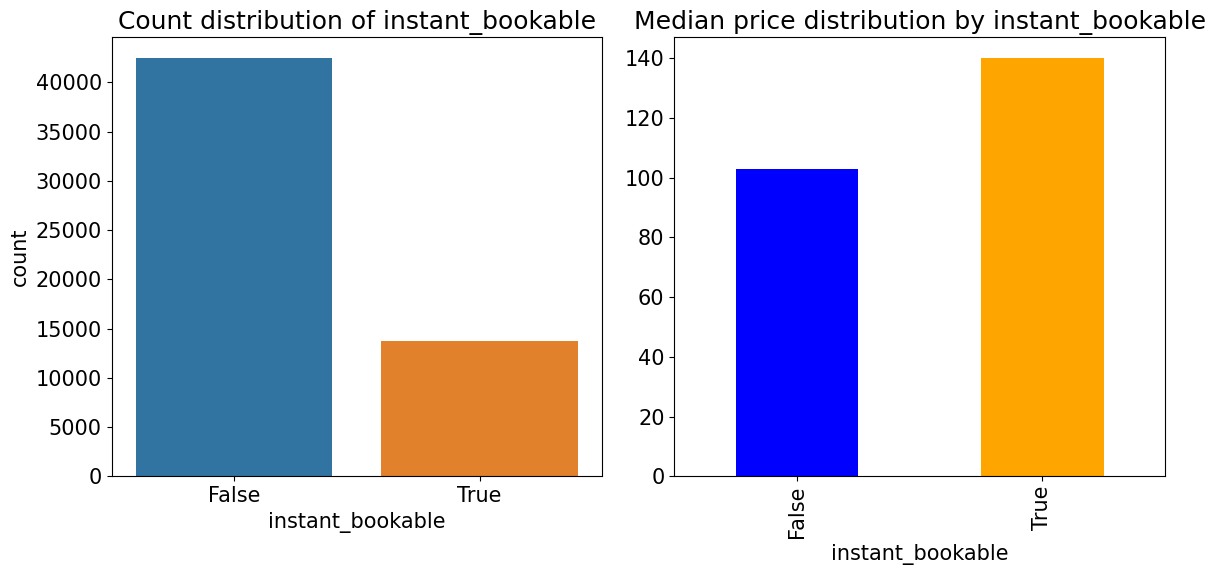

% Wise Split of instant_bookable:
instant_bookable
False    75.595514
True     24.404486
Name: proportion, dtype: float64

P-value for instant_bookable: 1.3076002698844885e-19
instant_bookable
False    0.755955
True     0.244045
Name: proportion, dtype: float64


In [29]:
from scipy.stats import ttest_ind
import seaborn as sns

def binary_count_and_price_plot(column_name):
    # Assuming df is your DataFrame

    # Plot count distribution
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.countplot(x=column_name, data=dataframe1)
    plt.title(f'Count distribution of {column_name}')

    # Plot median price distribution
    plt.subplot(1, 2, 2)
    median_prices = dataframe1.groupby(column_name)['price'].median()
    median_prices.plot(kind='bar', color=['blue', 'orange'])
    plt.title(f'Median price distribution by {column_name}')
    plt.tight_layout()
    plt.show()

    # Calculate t-test for median prices
    true_prices = dataframe1[dataframe1[column_name] == True]['price']
    false_prices = dataframe1[dataframe1[column_name] == False]['price']
    t_stat, p_value = ttest_ind(true_prices, false_prices)
   
    # Display additional information
    percent_split = dataframe1[column_name].value_counts(normalize=True) * 100
    print(f'% Wise Split of {column_name}:\n{percent_split}')
    t_statistic, p_value = ttest_ind(true_prices, false_prices, equal_var=False)  # assuming unequal variances
    print(f'\nP-value for {column_name}: {p_value}')

superhost = binary_count_and_price_plot('host_is_superhost')
print(dataframe1.host_is_superhost.value_counts(normalize=True))

test2 = binary_count_and_price_plot('host_identity_verified')
print(dataframe1.host_identity_verified.value_counts(normalize=True))

test3 = binary_count_and_price_plot('instant_bookable')
print(dataframe1.instant_bookable.value_counts(normalize=True))

In [ ]:
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = 20, 20
result = [binary_count_and_rating_plot(col) for col in dataframe1.iloc[:,44:-1].columns]

In [32]:
first_50_columns = dataframe1.iloc[:, :55]
print(first_50_columns.dtypes)

host_id                                                                     int64
host_since                                                         datetime64[ns]
host_response_time                                                         object
host_response_rate                                                         object
host_is_superhost                                                            bool
host_listings_count                                                       float64
host_total_listings_count                                                 float64
host_identity_verified                                                       bool
neighbourhood                                                              object
latitude                                                                  float64
longitude                                                                 float64
property_type                                                              object
room_type       

403